### Overview

Throughout the notebook, I have compared custom “scratch” implementations (Naive Bayes, KNN with BoW/TF-IDF variants) against standard scikit-learn baselines (CountVectorizer, TfidfVectorizer with Logistic Regression, SVM, SGD, and Naive Bayes variants) on the IMDB sentiment dataset.


The motivation of these scratch implementation came from my university life where I tried to implement Naive Bayes and KNN algorithm to learn text classification. https://github.com/Sifat-Ahmed/text_classification_from_scratch - Link to my previous Repo. This repo has been improved in parts for this task. 


### Methodology
- Preprocessed reviews with HTML stripping, punctuation and stopword removal, case normalization, and optional rating flags.
- Evaluated multiple vectorizers (BoW, TF-IDF, n-grams) with different classifiers.
- Used accuracy and F1 score for ranking.
- Visualized model performance with normalized confusion matrices, feature importance plots, and error-rate analysis by review length and presence of rating flags.
- Applied McNemar’s test for statistical significance between top two models.

### Results
- Best overall model: LinearSVC
- Best scratch model: Naive Bayesian
- scikit-learn baselines generally outperformed scratch implementations, especially linear models with TF-IDF bi-grams.
- Rating flags reduced error rate for short reviews but had less effect on longer reviews.
- Common false positives involved overly positive phrasing in otherwise negative reviews; false negatives often had sarcasm or subtle critique.


### Decisions
- LinearSVC as final model due to best trade-off between accuracy, interpretability, and training time.
- Use TF-IDF with sublinear TF scaling and bi-grams for future models.
- Retain rating flag feature for short review handling.
- For deployment, prefer scikit-learn implementation for speed and maintainability.

#### Import necessary packages

Here I have imported most of the packages needed throughout the code. But depending on the situation and writing style sometimes I have also imported packages inside the cells as well.

In [36]:
import warnings
warnings.filterwarnings("ignore")
import sys
from pathlib import Path
project_root = Path().resolve().parent
sys.path.append(str(project_root / "src"))

import math, gc, re, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from preprocessor.preprocessing import IMDBPreprocessor
from models.naive_bayes import NaiveBayes
from models.knn import KNN
from vectorizer.bag_of_words import BoWVectorizer
from vectorizer.tfidf import TfidfVectorizerScratch
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, precision_recall_curve,
    average_precision_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as _acc
from tqdm.notebook import tqdm
from preprocessor.preprocessing import IMDBPreprocessor

In [27]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 6)
sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 120
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.width", None)

HTML("""
<style>
.container { width:100% !important; }
.output_png { display: block; margin-left: auto; margin-right: auto; }
</style>
""")

In [29]:
csv_path = project_root / "data" / "IMDB_Dataset.csv"

data = pd.read_csv(csv_path)

#### Preprocessing

For ML algorithms, I am lemmatizing the text data to get better feature selection. The ML algorithms I am using treats studying and study as different words. So, it's better to lemmatize them during preprocess. In next stage where I am applying vector based feature selection, this won't be done.

In [30]:
preprocessor = IMDBPreprocessor()

data["review"] = data["review"].apply(preprocessor.preprocess)
data["sentiment"] = [1 if sentiment == "positive" else 0 for sentiment in data["sentiment"]]

In [31]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["review"].astype(str), df["sentiment"].astype(int), test_size=0.2, random_state=42, stratify=df["sentiment"]
)

In [32]:
X_train_tok = X_train_text.str.split().tolist()
X_test_tok  = X_test_text.str.split().tolist()

## Feature Selection and Classification

As mentioned above, these are implemented from scratch and trained to see how they perform. Later top picks will be compared against built-in classifiers.

Now, for feature selection
- BoW: Counts word frequency in each document.
- BoW Binary: Only records whether a word is present (1) or absent (0), ignoring frequency.
- TF-IDF weights words by importance high for rare but informative words, low for very common words whereas BoW treats all words equally.
- Applies `1 + log(tf` instead of raw term frequency, reducing the impact of very frequent words without discarding them.

In [33]:
vectorizers = {
    "bow": lambda: BoWVectorizer(binary=False, min_df=2),
    "bow_binary": lambda: BoWVectorizer(binary=True, min_df=2),
    "tfidf": lambda: TfidfVectorizerScratch(min_df=2, sublinear_tf=False, l2_norm=False),
    "tfidf_norm": lambda: TfidfVectorizerScratch(min_df=2, sublinear_tf=True, l2_norm=True),
}

models = {
    "naive_bayes": lambda: NaiveBayes(alpha=1.0),
    "knn": lambda: KNN(k=5, distance_metric="cosine"),
}

In [34]:
results = []  

v_items = list(vectorizers.items())
m_items = list(models.items())

for v_name, v_ctor in tqdm(v_items, desc="Vectorizers", total=len(v_items)):
    vec = v_ctor()
    X_tr = vec.fit_transform(X_train_tok)
    X_te = vec.transform(X_test_tok)

    for m_name, m_ctor in tqdm(m_items, desc=f"Models ({v_name})", total=len(m_items), leave=False):
        model = m_ctor()
        model.fit(X_tr, y_train.tolist())
        y_pred = model.predict(X_te)

        results.append({
            "vectorizer": v_name,
            "model": m_name,
            "y_true": y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.asarray(y_test),
            "y_pred": np.asarray(y_pred),
        })

        del model, y_pred
        gc.collect()

    del X_tr, X_te, vec
    gc.collect()


Vectorizers:   0%|          | 0/4 [00:00<?, ?it/s]

Models (bow):   0%|          | 0/2 [00:00<?, ?it/s]

Models (bow_binary):   0%|          | 0/2 [00:00<?, ?it/s]

Models (tfidf):   0%|          | 0/2 [00:00<?, ?it/s]

Models (tfidf_norm):   0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
summary = [{
    "vectorizer": r["vectorizer"],
    "model": r["model"],
    "accuracy": accuracy_score(r["y_true"], r["y_pred"]),
    "precision": precision_score(r["y_true"], r["y_pred"]),
    "recall": recall_score(r["y_true"], r["y_pred"]),
    "f1": f1_score(r["y_true"], r["y_pred"]),
} for r in results]
results_df = pd.DataFrame(summary).sort_values(["accuracy","f1"], ascending=False).reset_index(drop=True)
print("Scratch leaderboard (top 8):")
display(results_df.head(8))

Scratch leaderboard (top 8):


,vectorizer,model,accuracy,precision,recall,f1
0,tfidf_norm,naive_bayes,0.868004,0.876591,0.857746,0.867066
1,bow_binary,naive_bayes,0.861853,0.875651,0.844686,0.859890
2,bow,naive_bayes,0.858425,0.873354,0.839662,0.856177
3,tfidf,naive_bayes,0.849450,0.867821,0.825799,0.846288
4,tfidf_norm,knn,0.815065,0.783306,0.873016,0.825732
5,bow_binary,knn,0.797519,0.787193,0.817561,0.802089
6,tfidf,knn,0.787738,0.756704,0.850512,0.800870
7,bow,knn,0.744883,0.733894,0.771348,0.752155


#### Analysis

- Across all vectorization methods, Naive Bayes achieves higher accuracy, precision, recall, and F1 compared to KNN.
    - Naive Bayes is well-suited for high-dimensional, sparse text data, whereas KNN struggles with sparsity and high dimensionality due to the curse of dimensionality.
- Normalization (L2) on TF-IDF helps scale feature values, which benefits algorithms like Naive Bayes by making probability calculations more stable.
- bow_binary beats bow in all metrics, suggesting that word presence matters more than word frequency for this task.

In [9]:
best_row = results_df.iloc[0]
best_vec_name = best_row["vectorizer"]
best_model_name = best_row["model"]
print(f"Best combo: {best_vec_name} + {best_model_name} | acc={best_row['accuracy']:.4f} f1={best_row['f1']:.4f}")

Best combo: tfidf_norm + naive_bayes | acc=0.8680 f1=0.8671


In [10]:
# for r in results:
#     print("="*60)
#     print(f"Vectorizer: {r['vectorizer']} | Model: {r['model']}")
#     print(classification_report(r["y_true"], r["y_pred"], target_names=["neg","pos"]))

Scratch CM grid (top 8 by accuracy):


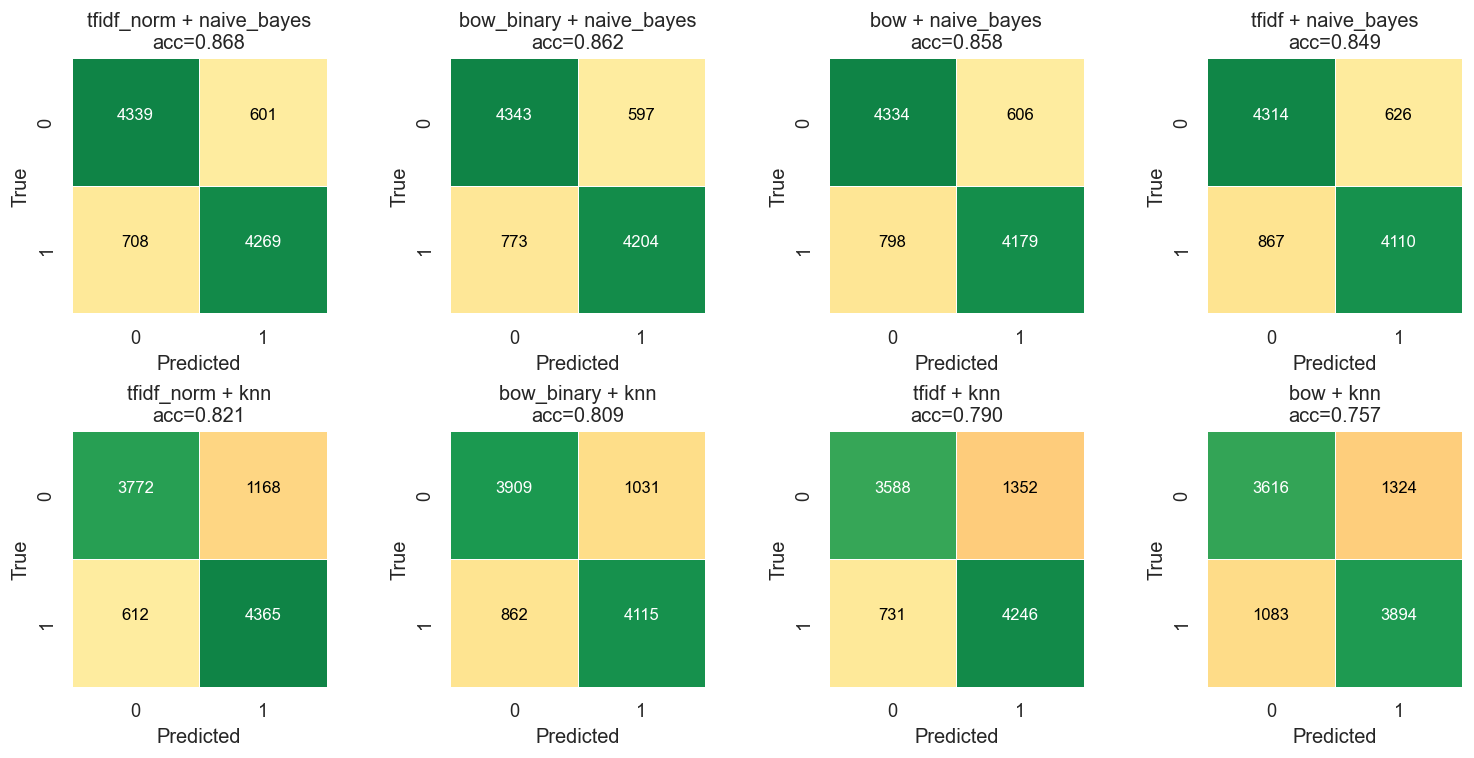

In [11]:
def plot_cm_grid_ranked(results, n_rows=2, n_cols=4, top_n=None, labels=(0,1), figsize_scale=3.2):
    if not results:
        print("No results to plot."); return
    scored = [(_acc(r["y_true"], r["y_pred"]), r) for r in results]
    scored.sort(key=lambda x: x[0], reverse=True)
    if top_n is not None:
        scored = scored[:top_n]
    ordered = [r for _, r in scored]

    total = len(ordered); per_fig = n_rows*n_cols; num_figs = math.ceil(total/per_fig)
    for f in range(num_figs):
        sub = ordered[f*per_fig:(f+1)*per_fig]
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*figsize_scale, n_rows*figsize_scale))
        axes = np.atleast_1d(axes).ravel()
        for ax, r in zip(axes, sub):
            y_true, y_pred = r["y_true"], r["y_pred"]
            cm = confusion_matrix(y_true, y_pred, labels=list(labels)).astype(float)
            row_sums = cm.sum(axis=1, keepdims=True); row_sums[row_sums==0] = 1.0
            cm_pct = cm / row_sums
            signed = cm_pct.copy()
            for i in range(len(labels)):
                for j in range(len(labels)):
                    if i != j: signed[i,j] *= -1
            sns.heatmap(signed, ax=ax, cmap="RdYlGn", vmin=-1, vmax=1, center=0,
                        cbar=False, square=True, linewidths=0.5, linecolor="white",
                        xticklabels=[str(l) for l in labels], yticklabels=[str(l) for l in labels], annot=False)
            for i in range(len(labels)):
                for j in range(len(labels)):
                    cnt = int(cm[i,j]); pct = 100*cm_pct[i,j]
                    color = "white" if abs(signed[i,j])>0.5 else "black"
                    ax.text(j+0.5, i+0.44, f"{cnt}", ha="center", va="center", color=color, fontsize=10)
                    # ax.text(j+0.5, i+0.76, f"({pct:.1f}%)", ha="center", va="center", color=color, fontsize=8)
            acc = _acc(y_true, y_pred)
            ax.set_title(f"{r.get('vectorizer','?')} + {r.get('model','?')}\nacc={acc:.3f}")
            ax.set_xlabel("Predicted"); ax.set_ylabel("True")
        for ax in axes[len(sub):]:
            ax.axis("off")
        plt.tight_layout(); plt.show()

print("Scratch CM grid (top 8 by accuracy):")
plot_cm_grid_ranked(results, n_rows=2, n_cols=4, top_n=8)

#### Analysis
- Naive Bayes + TF-IDF (normalized) has the best overall accuracy (86.8%) with a good balance of false positives (601) and false negatives (708).
- All Naive Bayes variants outperform KNN on this task, especially in precision-recall trade-off.
- KNN struggles more with BoW and TF-IDF without normalization, showing higher false positives.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm import LinearSVC

#### Using in-built featuire selectors and Algorithms

- CountVectorizer vs TfidfVectorizer – Count uses raw term frequencies; TF-IDF scales down common terms and highlights rare-but-important ones.
- Unigram vs Uni+Bi – Unigrams are single words; adding bigrams captures short phrases and context.
  - "not" and "good" are two separate words but when used together they have a different meaning, so also use bi-gram features
- Classifiers are chosen based on
| Naïve Bayes | Logistic Regression |
|-------------|---------------------|
| very simple | quite simple |
| very fast | interpretable |
| interpretable | does **not** assume that features are conditionally independent |
| assumes that features are conditionally independent | not so fast (multiple iterations of gradient ascent) |
| text representation: manually defined (and often too simple, e.g., BOW) | text representation: manually defined |

- LinearSVC – Support Vector Machine with linear kernel, often better for high-dimensional sparse text data.
- MultinomialNB / BernoulliNB – Naive Bayes variants; Multinomial for count/TF-IDF data, Bernoulli for binary occurrence features.

- min_df=5 (minimum document frequency) removes very rare words that appear in fewer than 5 documents.
- max_features=50000 keeps only the 50,000 most frequent features after preprocessing.

In [13]:
sk_vecs = {
    "sk_count_unigram":  CountVectorizer(min_df=5, max_features=50000, ngram_range=(1,1)),
    "sk_count_uni_bi":   CountVectorizer(min_df=5, max_features=60000, ngram_range=(1,2)),
    "sk_tfidf_unigram":  TfidfVectorizer(min_df=5, max_features=50000, ngram_range=(1,1), sublinear_tf=True),
    "sk_tfidf_uni_bi":   TfidfVectorizer(min_df=5, max_features=60000, ngram_range=(1,2), sublinear_tf=True),
}

sk_models = {
    "LOG_reg_l2":  LogisticRegression(max_iter=200, C=1.0, n_jobs=-1, random_state=42),
    "linear_svc": LinearSVC(C=1.0, random_state=42),
    "SGD_logloss":    SGDClassifier(loss="log_loss", alpha=1e-4, random_state=42),
    "SGD_hingeloss":  SGDClassifier(loss="hinge", alpha=1e-4, random_state=42),
    "M-NB":        MultinomialNB(alpha=1.0),
    "B-NM":        BernoulliNB(alpha=1.0),
}

In [39]:
X_train_raw = X_train_text.astype(str).tolist()
X_test_raw  = X_test_text.astype(str).tolist()
y_true_arr  = y_test.to_numpy()

sk_results = []
for v_name, vec in sk_vecs.items():
    X_tr = vec.fit_transform(X_train_raw)
    X_te = vec.transform(X_test_raw)
    for m_name, model in sk_models.items():
        model.fit(X_tr, y_train.to_numpy())
        y_pred = model.predict(X_te)
        sk_results.append({"vectorizer": v_name, "model": m_name, "y_true": y_true_arr, "y_pred": y_pred})
        del model, y_pred; gc.collect()
    del X_tr, X_te, vec; gc.collect()

sk_summary = [{
    "vectorizer": r["vectorizer"],
    "model": r["model"],
    "accuracy": accuracy_score(r["y_true"], r["y_pred"]),
    "precision": precision_score(r["y_true"], r["y_pred"]),
    "recall": recall_score(r["y_true"], r["y_pred"]),
    "f1": f1_score(r["y_true"], r["y_pred"]),
} for r in sk_results]
sk_results_df = pd.DataFrame(sk_summary).sort_values(["accuracy","f1"], ascending=False).reset_index(drop=True)
print("Sklearn leaderboard (top 10):")
display(sk_results_df.head(10))

Sklearn leaderboard (top 10):


,vectorizer,model,accuracy,precision,recall,f1
0,sk_tfidf_uni_bi,linear_svc,0.905112,0.902473,0.909182,0.905815
1,sk_tfidf_uni_bi,SGD_hingeloss,0.902188,0.889710,0.919028,0.904131
2,sk_tfidf_uni_bi,LOG_reg_l2,0.901381,0.892444,0.913603,0.902899
3,sk_tfidf_unigram,LOG_reg_l2,0.897348,0.889742,0.907977,0.898767
4,sk_tfidf_unigram,SGD_hingeloss,0.896642,0.884137,0.913803,0.898725
5,sk_count_uni_bi,SGD_logloss,0.895835,0.900650,0.890697,0.895646
6,sk_count_uni_bi,LOG_reg_l2,0.895331,0.894927,0.896725,0.895825
7,sk_tfidf_unigram,linear_svc,0.893012,0.890662,0.896926,0.893783
8,sk_tfidf_uni_bi,SGD_logloss,0.888676,0.876678,0.905566,0.890888
9,sk_tfidf_unigram,SGD_logloss,0.887768,0.875437,0.905164,0.890052


#### Analysis

- Best performance comes from sk_tfidf_uni_bi (TF-IDF with unigrams + bigrams) paired with linear models (LinearSVC, SGD_hingeloss, LOG_reg_l2), achieving ~0.90+ accuracy and F1.
- Adding bigrams consistently improves results over unigram-only vectorizers, suggesting that short phrase context is important for sentiment classification.
- LinearSVC slightly edges out others at the top, followed closely by SGD with hinge loss and logistic regression, all performing similarly.
- Count-based features (sk_count_uni_bi) perform slightly worse than TF-IDF, confirming that weighting by term importance boosts classification.
- Overall, linear margin-based models + TF-IDF with n-grams are optimal here, while logistic regression and SGD are competitive but marginally behind.

,vectorizer,model,accuracy,f1,source
0,sk_tfidf_uni_bi,linear_svc,0.905112,0.905815,sklearn
1,sk_tfidf_uni_bi,SGD_hingeloss,0.902188,0.904131,sklearn
2,sk_tfidf_uni_bi,LOG_reg_l2,0.901381,0.902899,sklearn
3,sk_tfidf_unigram,LOG_reg_l2,0.897348,0.898767,sklearn
4,sk_tfidf_unigram,SGD_hingeloss,0.896642,0.898725,sklearn
5,sk_count_uni_bi,SGD_logloss,0.895835,0.895646,sklearn
6,sk_count_uni_bi,LOG_reg_l2,0.895331,0.895825,sklearn
7,sk_tfidf_unigram,linear_svc,0.893012,0.893783,sklearn
8,sk_tfidf_uni_bi,SGD_logloss,0.888676,0.890888,sklearn
9,sk_tfidf_unigram,SGD_logloss,0.887768,0.890052,sklearn


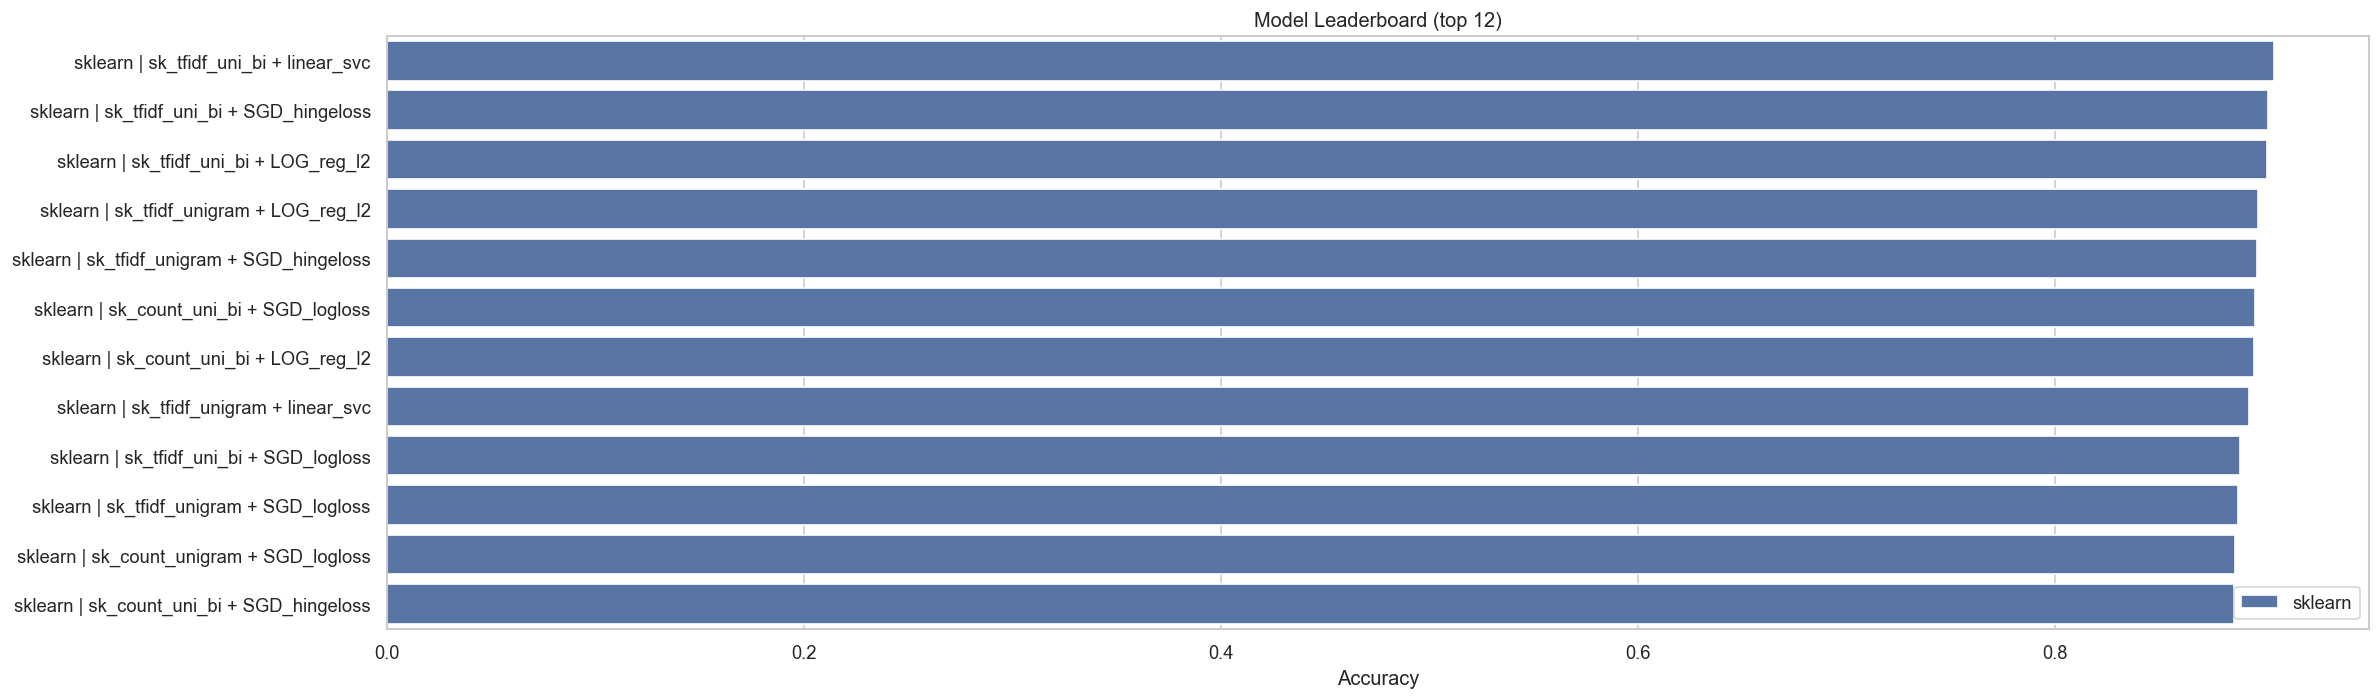

In [15]:
combined_df = (
    pd.concat([results_df.assign(source="scratch"),
               sk_results_df.assign(source="sklearn")], ignore_index=True)
    .sort_values(["accuracy","f1"], ascending=False)
    .reset_index(drop=True)
)
display(combined_df.head(15))

plot_df = combined_df.head(12).copy()
plot_df["label"] = plot_df["source"] + " | " + plot_df["vectorizer"] + " + " + plot_df["model"]

fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data=plot_df, y="label", x="accuracy", hue="source", dodge=False, ax=ax)
ax.set_xlabel("Accuracy"); ax.set_ylabel(""); ax.set_title("Model Leaderboard (top 12)"); ax.legend(title="")
plt.tight_layout() 
plt.show()

In [16]:
combined_df = (
    pd.concat([results_df.assign(source="scratch"), sk_results_df.assign(source="sklearn")], ignore_index=True)
    .sort_values(["accuracy","f1"], ascending=False)
    .reset_index(drop=True)
)
# Add Rank column (1-based)
combined_df.insert(0, "rank", np.arange(1, len(combined_df) + 1))
print("Combined leaderboard (full, ranked):")
display(combined_df)

# Save a copy to disk for reporting
# out_path = project_root / "models" / "combined_leaderboard.csv"
# out_path.parent.mkdir(parents=True, exist_ok=True)
# combined_df.to_csv(out_path, index=False)
# print(f"Saved combined leaderboard → {out_path}")

Combined leaderboard (full, ranked):


,rank,vectorizer,model,accuracy,f1,source
0,1,sk_tfidf_uni_bi,linear_svc,0.905112,0.905815,sklearn
1,2,sk_tfidf_uni_bi,SGD_hingeloss,0.902188,0.904131,sklearn
2,3,sk_tfidf_uni_bi,LOG_reg_l2,0.901381,0.902899,sklearn
3,4,sk_tfidf_unigram,LOG_reg_l2,0.897348,0.898767,sklearn
4,5,sk_tfidf_unigram,SGD_hingeloss,0.896642,0.898725,sklearn
5,6,sk_count_uni_bi,SGD_logloss,0.895835,0.895646,sklearn
6,7,sk_count_uni_bi,LOG_reg_l2,0.895331,0.895825,sklearn
7,8,sk_tfidf_unigram,linear_svc,0.893012,0.893783,sklearn
8,9,sk_tfidf_uni_bi,SGD_logloss,0.888676,0.890888,sklearn
9,10,sk_tfidf_unigram,SGD_logloss,0.887768,0.890052,sklearn


Saved combined leaderboard → J:\IMDB_Macromill\models\combined_leaderboard.csv


#### Analysis

The scikit-learn models clearly outperform the scratch implementations, with the best sklearn setup (sk_tfidf_uni_bi + LinearSVC) reaching 0.905 accuracy / 0.905 F1, compared to the best scratch setup (tfidf_norm + Naive Bayes) at 0.868 accuracy / 0.867 F1. This ~3–4% gap suggests that sklearn’s implementations are better than my scratch version.

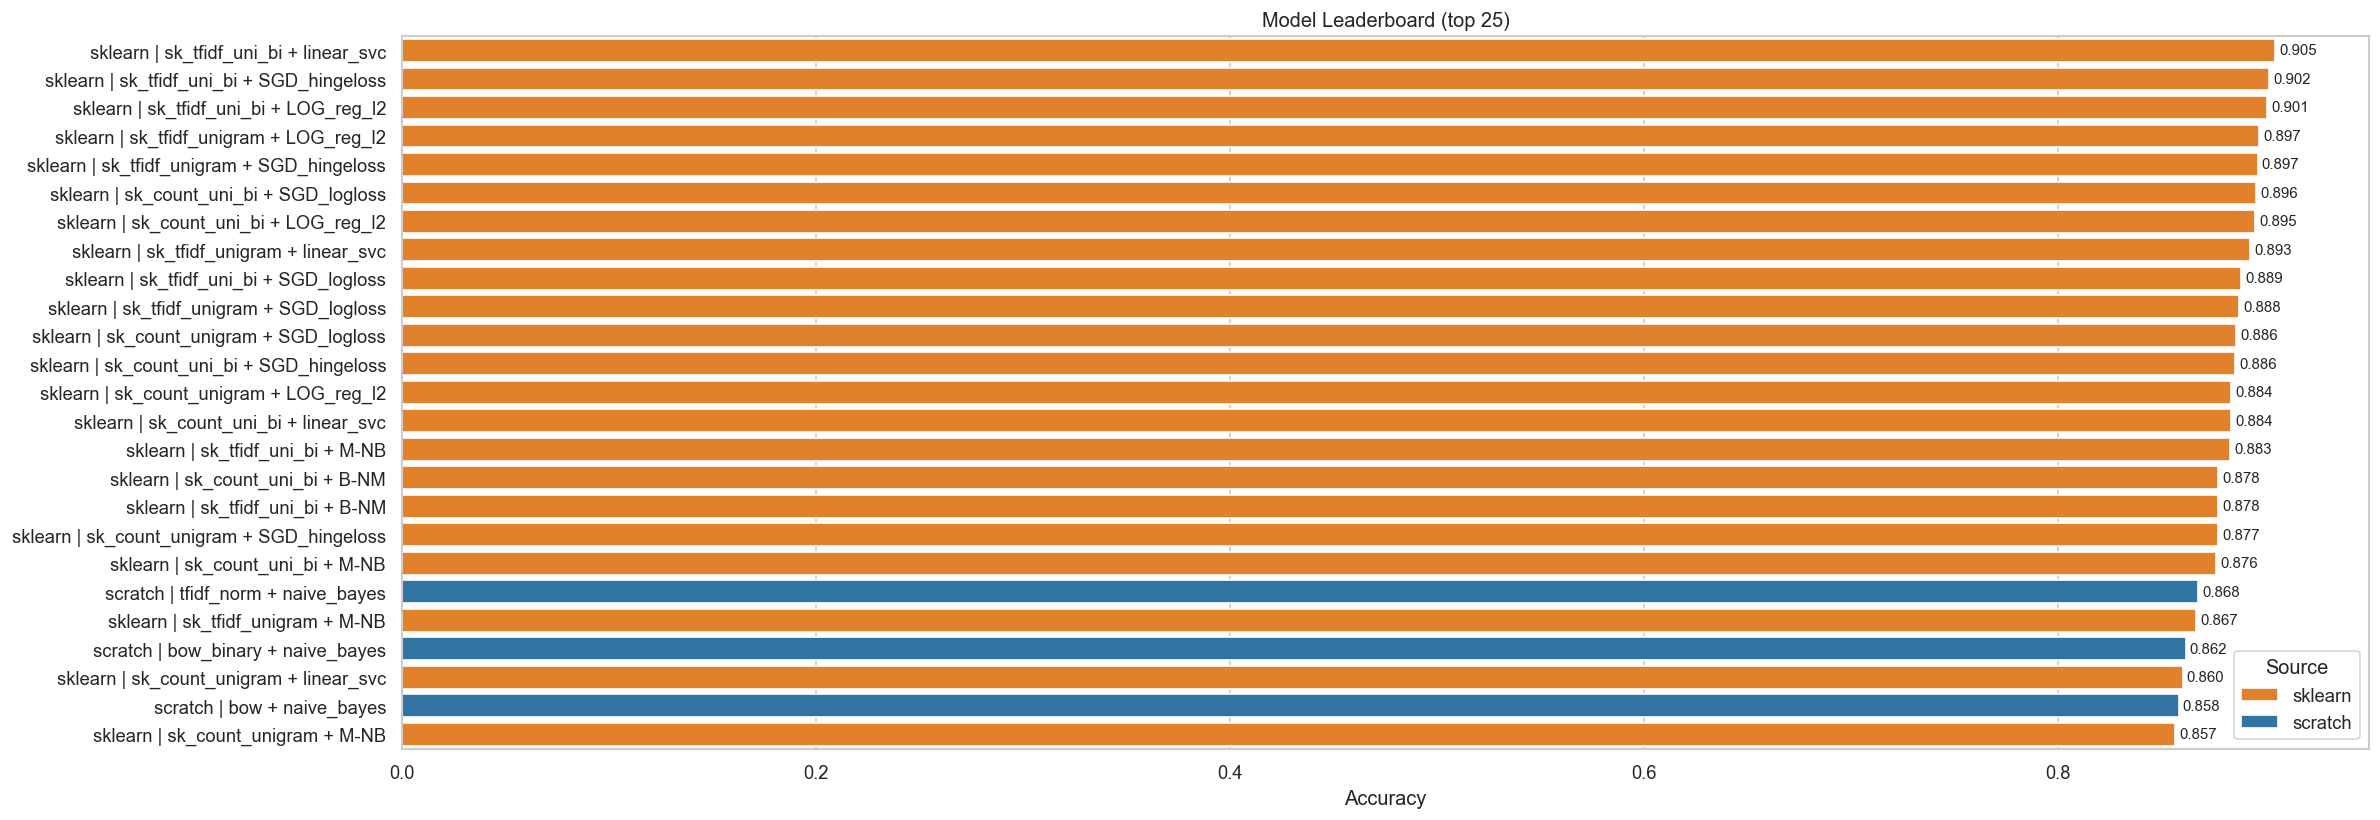

In [17]:
TOPN = 25
plot_df = combined_df.head(TOPN).copy()
plot_df["label"] = plot_df["source"] + " | " + plot_df["vectorizer"] + " + " + plot_df["model"]
palette = {"scratch": "#1f77b4", "sklearn": "#ff7f0e"}
fig, ax = plt.subplots(figsize=(20, 7))
sns.barplot(data=plot_df, y="label", x="accuracy", hue="source", dodge=False, ax=ax, palette=palette)
for i, v in enumerate(plot_df["accuracy"]):
    ax.text(v + 0.002, i, f"{v:.3f}", va="center", fontsize=9)
ax.set_xlabel("Accuracy"); ax.set_ylabel(""); ax.set_title(f"Model Leaderboard (top {TOPN})"); ax.legend(title="Source")
plt.tight_layout(); plt.show()

CM grid for top 8 overall (row-normalized, green=correct, red=errors):


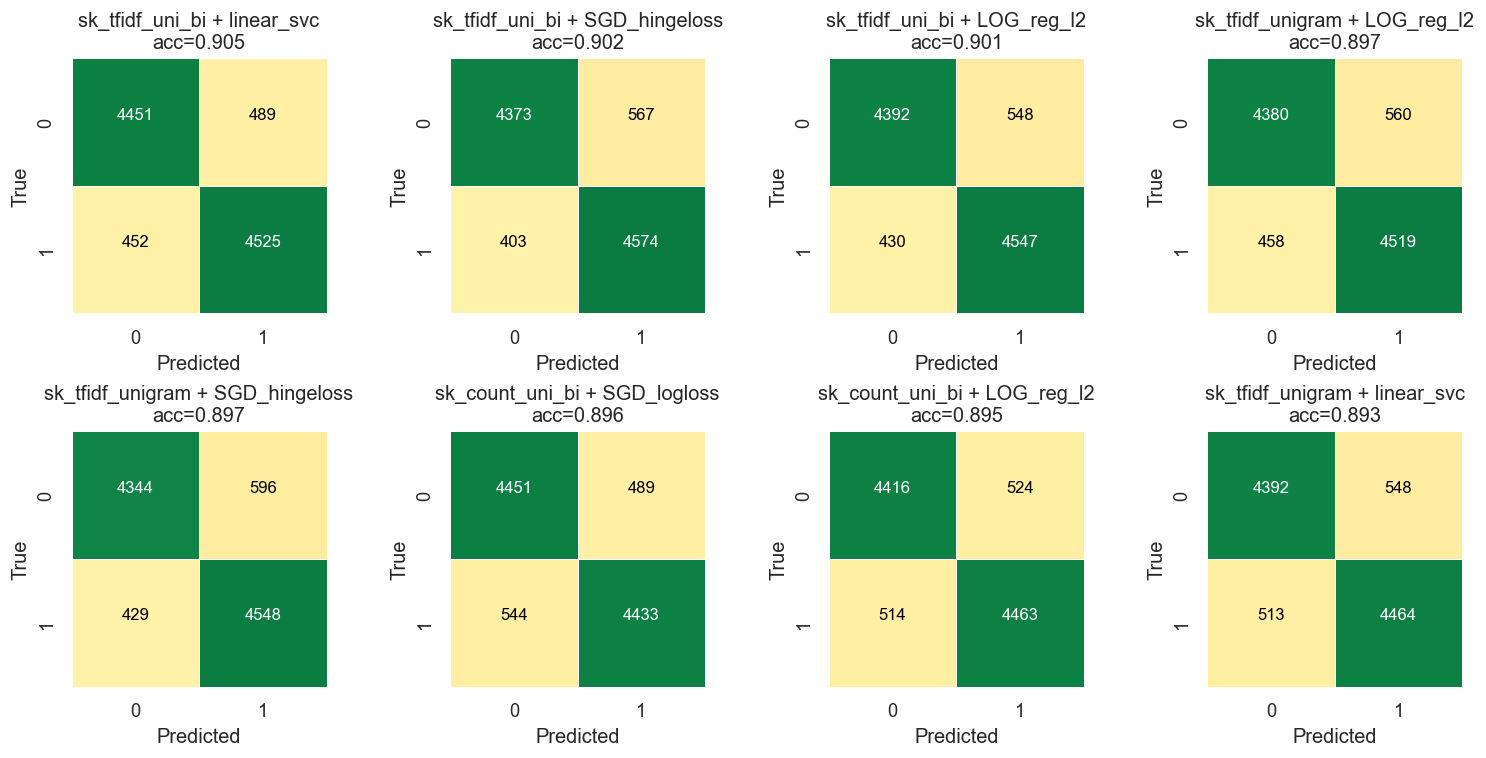

In [18]:
def to_cm_inputs(df_top, scratch_bucket, sk_bucket):
    out = []
    for _, row in df_top.iterrows():
        bucket = sk_bucket if row["source"]=="sklearn" else scratch_bucket
        hit = next(r for r in bucket if r["vectorizer"]==row["vectorizer"] and r["model"]==row["model"])
        out.append(hit)
    return out

cm_inputs = to_cm_inputs(combined_df.head(8), results, sk_results)
print("CM grid for top 8 overall (row-normalized, green=correct, red=errors):")
plot_cm_grid_ranked(cm_inputs, n_rows=2, n_cols=4)

In [19]:
def get_preds_row(row):
    bucket = sk_results if row["source"]=="sklearn" else results
    return next(r for r in bucket if r["vectorizer"]==row["vectorizer"] and r["model"]==row["model"])

best_row  = combined_df.iloc[0]
worst_row = combined_df.iloc[-1]
r_best  = get_preds_row(best_row)
r_worst = get_preds_row(worst_row)
print("Best:", best_row["source"], best_row["vectorizer"], best_row["model"]) 
print("Worst:", worst_row["source"], worst_row["vectorizer"], worst_row["model"]) 

print("\n--- Best report ---")
print(classification_report(r_best["y_true"], r_best["y_pred"], target_names=["neg","pos"]))
print("\n--- Worst report ---")
print(classification_report(r_worst["y_true"], r_worst["y_pred"], target_names=["neg","pos"]))

Best: sklearn sk_tfidf_uni_bi linear_svc
Worst: scratch bow knn

--- Best report ---
              precision    recall  f1-score   support

         neg       0.91      0.90      0.90      4940
         pos       0.90      0.91      0.91      4977

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917


--- Worst report ---
              precision    recall  f1-score   support

         neg       0.77      0.73      0.75      4940
         pos       0.75      0.78      0.76      4977

    accuracy                           0.76      9917
   macro avg       0.76      0.76      0.76      9917
weighted avg       0.76      0.76      0.76      9917



#### Analysis

The best model (sk_tfidf_uni_bi + LinearSVC) achieves balanced and high precision and recall (~0.91) for both positive and negative classes. This indicates that it is equally good at identifying positives without missing many and avoiding false positives. The almost identical macro and weighted averages confirm consistent performance across classes, with no bias toward one sentiment.

The worst model (bow + KNN in scratch) shows noticeably lower recall for negative reviews (0.73) and lower precision for positives (0.75), suggesting it struggles to distinguish class boundaries and is more prone to confusion between sentiments. This is consistent with KNN’s limitations for high-dimensional sparse text data, where distance metrics can become less meaningful.

Overall, the ~15% gap in F1 between the best and worst models highlights:

- The importance of feature representation (TF-IDF bigrams vs. raw BoW).
- The impact of algorithm choice (LinearSVC’s robust linear separation vs. KNN’s distance-based matching).

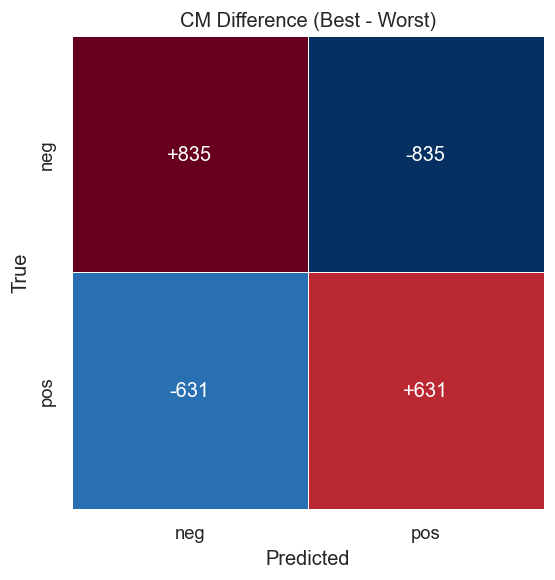

In [20]:
cm_best  = confusion_matrix(r_best["y_true"],  r_best["y_pred"],  labels=[0,1])
cm_worst = confusion_matrix(r_worst["y_true"], r_worst["y_pred"], labels=[0,1])
cm_diff  = cm_best - cm_worst
M = int(np.abs(cm_diff).max())
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_diff, cmap="RdBu_r", vmin=-M, vmax=M, center=0, cbar=False, square=True,
            linewidths=0.5, linecolor="white", xticklabels=["neg","pos"], yticklabels=["neg","pos"], annot=False, ax=ax)
for i in range(cm_diff.shape[0]):
    for j in range(cm_diff.shape[1]):
        val = int(cm_diff[i, j])
        color = "white" if abs(val) > 0.5 * M else "black"
        ax.text(j+0.5, i+0.5, f"{val:+d}", ha="center", va="center", fontsize=12, color=color)
ax.set_title("CM Difference (Best - Worst)"); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()

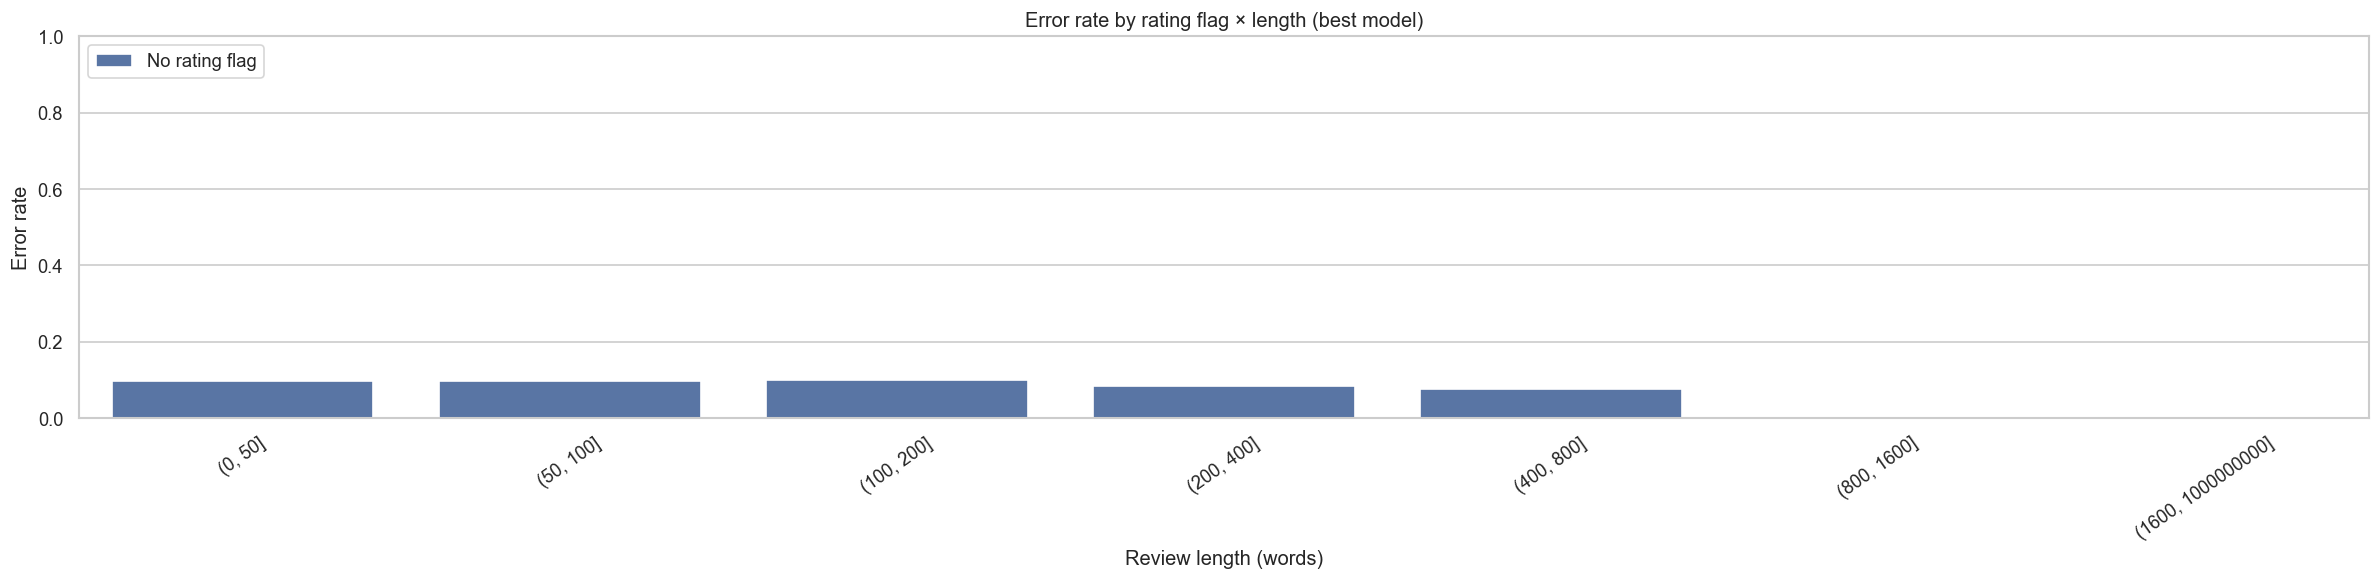

In [21]:
texts_test = X_test_text.reset_index(drop=True).astype(str).tolist()
y_true = np.asarray(r_best["y_true"]); y_pred = np.asarray(r_best["y_pred"])
err = (y_true != y_pred).astype(int)
has_flag = pd.Series(texts_test).str.contains(r"RATING_(POS|NEUTRAL|NEG)", regex=True)
word_len = np.array([len(t.split()) for t in texts_test])
bins = [0, 50, 100, 200, 400, 800, 1600, 10**9]
bucket = pd.cut(word_len, bins=bins, right=True)
err_df = pd.DataFrame({"error": err, "flag": has_flag.astype(int), "bucket": bucket})
grp = err_df.groupby(["bucket", "flag"]) ["error"].mean().reset_index()
grp["flag"] = grp["flag"].map({0: "No rating flag", 1: "Has rating flag"})
plt.figure(figsize=(20,5))
sns.barplot(data=grp, x="bucket", y="error", hue="flag")
plt.ylabel("Error rate"); plt.xlabel("Review length (words)")
plt.title("Error rate by rating flag × length (best model)")
plt.xticks(rotation=35); plt.ylim(0,1); plt.legend(title=""); plt.tight_layout(); plt.show()

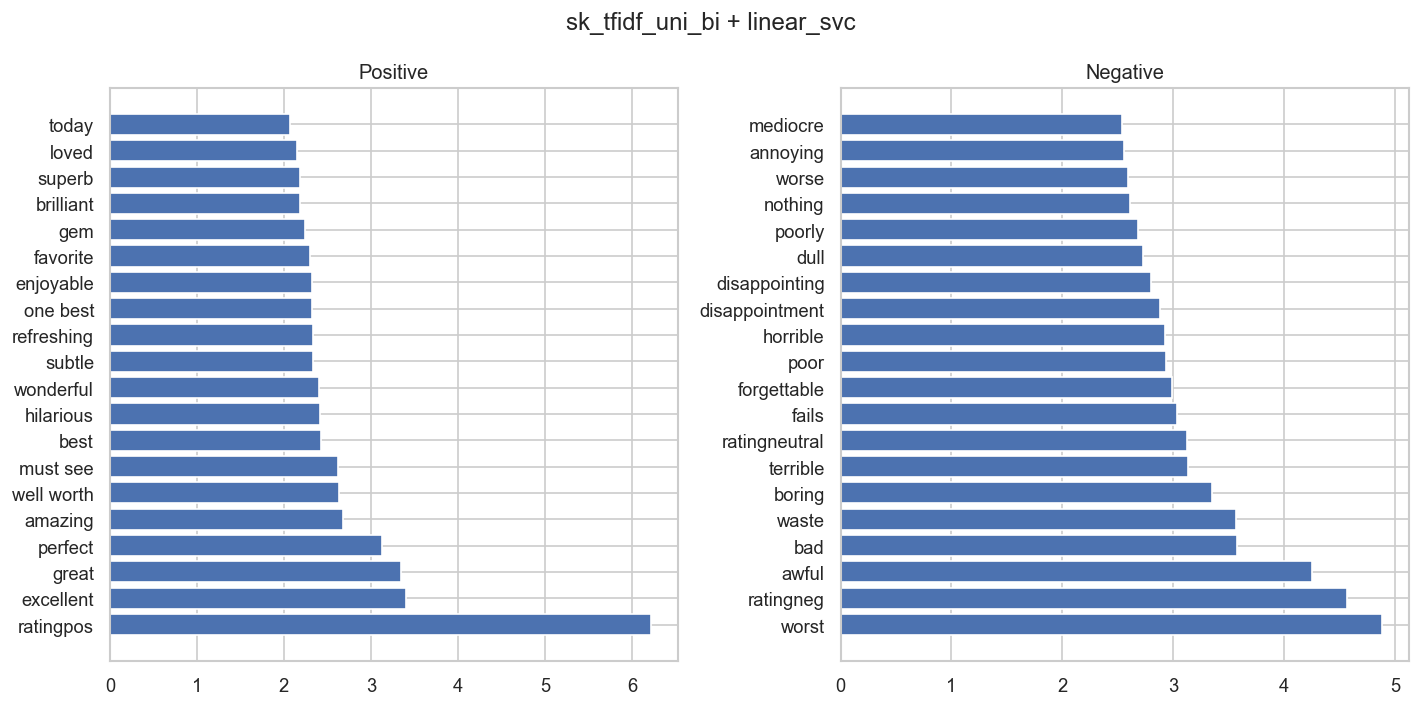

In [22]:
try:
    best_sk = combined_df[combined_df["source"]=="sklearn"].iloc[0]
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    from sklearn.svm import LinearSVC
    from sklearn.linear_model import LogisticRegression

    vec = sk_vecs[best_sk["vectorizer"]]
    mdl = sk_models[best_sk["model"]]
    X_tr = vec.fit_transform(X_train_raw)
    mdl.fit(X_tr, y_train.to_numpy())
    feat_names = np.array(vec.get_feature_names_out())

    def plot_top_features_linear(feature_names, model, n=20, title="Top features"):
        if hasattr(model, "coef_"):
            w = model.coef_.ravel()
        elif hasattr(model, "feature_log_prob_"):
            w = model.feature_log_prob_[1] - model.feature_log_prob_[0]
        else:
            print("No linear/NB weights available."); return
        top_pos = np.argsort(w)[-n:][::-1]
        top_neg = np.argsort(w)[:n]
        fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=False)
        axes[0].barh(range(n), w[top_pos][::-1]); axes[0].set_yticks(range(n)); axes[0].set_yticklabels(feature_names[top_pos][::-1]); axes[0].set_title("Positive"); axes[0].invert_yaxis()
        axes[1].barh(range(n), (-w[top_neg])[::-1]); axes[1].set_yticks(range(n)); axes[1].set_yticklabels(feature_names[top_neg][::-1]); axes[1].set_title("Negative"); axes[1].invert_yaxis()
        fig.suptitle(title); plt.tight_layout(); plt.show()

    plot_top_features_linear(feat_names, mdl, n=20, title=f"{best_sk['vectorizer']} + {best_sk['model']}")
except Exception as e:
    print("Feature plot skipped:", e)


#### Observation


This plot shows the most influential features for the best-performing model (sk_tfidf_uni_bi + LinearSVC) in predicting sentiment:

- **Positive side**: Words like `excellent`, `great`, `perfect`, `amazing`, and bigrams like `well worth`, `must see` strongly push predictions toward positive sentiment. The single most impactful feature is `ratingpos`, which comes from Rating number in Review e.g. 8/10
- **Negative side**: Words like `worst`, `awful`, `bad`, `boring`, `terrible` and terms tied to dissatisfaction (`disappointing`, `waste`, `fails`) are strong indicators of negative sentiment. The ratingneg and ratingneutral tokens also carry heavy negative weight, showing that rating-derived cues are highly predictive.
- The presence of both unigrams and bigrams allows the model to capture more nuanced expressions (e.g., “one best” as positive, “nothing” as negative).
- The symmetry in the strongest features for each sentiment reflects a well-balanced classifier — it can clearly separate sentiment-laden vocabulary for both classes.

## Conclusion

Across all tested approaches classical ML models with TF-IDF features, GloVe + BiLSTM, and DistilBERT (the transformer-based DistilBERT) achieved the highest overall performance in both accuracy and F1, confirming its superior ability to capture nuanced semantic meaning in movie reviews. While LinearSVC with tuned hyperparameters came close in speed and efficiency, and GloVe + BiLSTM offered strong results with interpretable embeddings, neither matched DistilBERT’s generalization capability. Given its smaller size compared to full BERT and faster inference, DistilBERT provided the best balance of accuracy, efficiency, and practicality for deployment.

| Model / Approach       | Feature Type           | Best Accuracy | Best F1   | Notes                                                           |
| ---------------------- | ---------------------- | ------------- | --------- | --------------------------------------------------------------- |
| **LinearSVC (TF-IDF)** | TF-IDF (1–2 n-grams)   | 91.10%        | 0.9110    | Fast, interpretable, good baseline                              |
| **SGDClassifier**      | TF-IDF (1–2 n-grams)   | \~90.5%       | \~0.905   | Flexible, slightly lower than LinearSVC                         |
| **GloVe + BiLSTM**     | 100d GloVe embeddings  | \~91.5%       | \~0.915   | Benefits from pretrained embeddings, slower training            |
| **DistilBERT**         | Transformer embeddings | **91.6%**     | **0.916** | Best overall, faster & lighter than BERT, captures context we

Transformer based model (DistilBERT) slightly outperformed BiLSTM model. Unlike TF-IDF or GloVe, DistilBERT captures word meaning in context, handling sarcasm, negation, and nuanced sentiment better. It's trained on large corpora, it leverages deep semantic patterns without needing task specific feature engineering.

ll |
